# Deflection Parametric Study
This file presents a parametric study for the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def plot(mc):
    fig, ax = plt.subplots(1, 1)
    dp = DeflectionProfile(mc=mc)
    F, w = dp.get_Fw()
    ax.plot(w, F / 1000, c= 'blue', label= 'bmcs_deflection'); ax.legend()
    ax.set_xlabel(r'$w$ [mm]')
    ax.set_ylabel(r'$F$ [kN]')
    plt.show()
    
def plot_fw_ver(mc, ver_data, L):
    fig, ax = plt.subplots(1,1)
    dp.plot_fw(ax)
    w = ver_data[0]
    f = ver_data[1]
    ax.plot(w, f, c= 'red', label= 'Experiment')
    ax.plot([L/250 , L/250], [0, max(f)],  c='black', ls= '--' ); plt.annotate('L/500', xy=(L/500, max(f)))
    ax.plot([L/500 , L/500], [0, max(f)],  c='black', ls= ':' ); plt.annotate('L/250', xy=(L/250, max(f)))
    ax.legend()
    plt.show()
    
def plot_parametric_study(ver_data):
    for i in range(12):
#         ax = "ax" + str(i)
        plt.subplot(4,3,i+1)
        plt.gcf().set_size_inches(15, 10)
#         dp.plot_fw(ax)
#         w = ver_data[0]
#         f = ver_data[1]
#         ax.plot(w, f, c= 'red', label= 'Experiment')
#         ax.set_title("ax")

#     for i in range(15):
#         ax = 'ax' + 'i'
#         fig, (ax) = plt.subplots(5,3)
# #         dp.plot_fw(ax)
#         w = ver_data[0]
#         f = ver_data[1]
#         ax.plot(w, f, c= 'red', label= 'Experiment')
#         ax.legend()
#         plt.show()

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

In [4]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Bielak (2019), https://doi.org/10.3390/app9071382, Carbon reinforcement

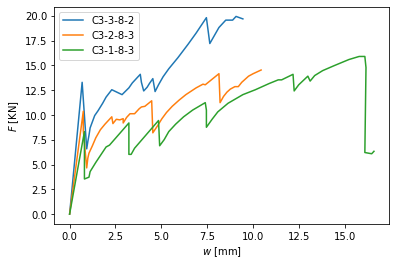

In [5]:
excel_file = join('./verification_data/Bie19','Bielak_2019.xlsx')
data = pd.read_excel(excel_file)

w_= data['C3-3-8-2_w']  ; f_= data['C3-3-8-2_F'] ; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'C3-3-8-2')
w_1= data['C3-2-8-3_w']  ; f_1= data['C3-2-8-3_F'] ; ver_data1 = [w_1, f_1]; plt.plot(w_1,f_1, label = 'C3-2-8-3')
w_2= data['C3-1-8-3_w']  ; f_2= data['C3-1-8-3_F'] ; ver_data2 = [w_2, f_2]; plt.plot(w_2,f_2, label = 'C3-1-8-3')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

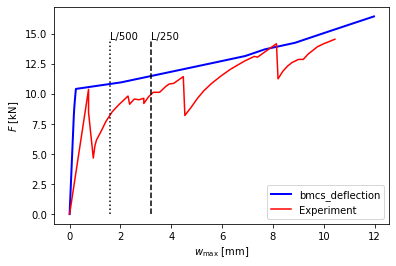

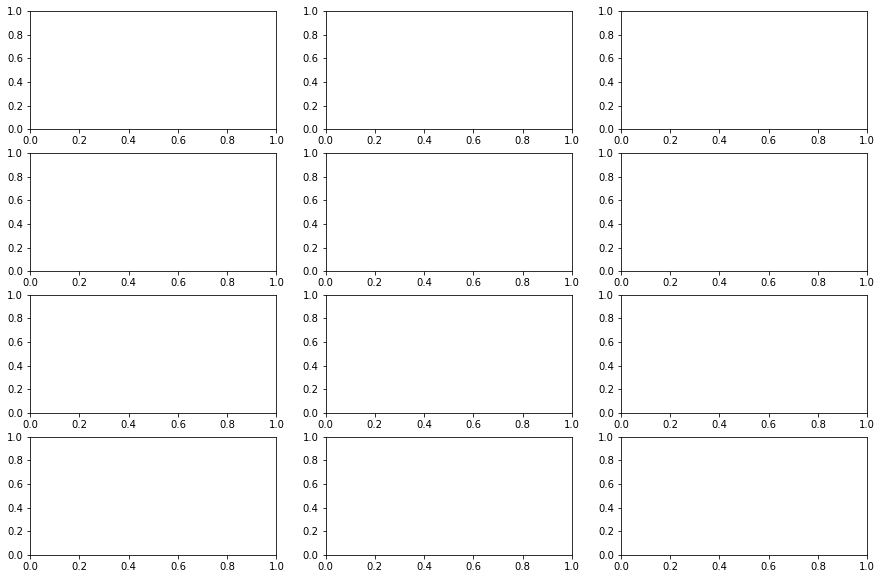

In [6]:
# C3-2-8-3
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

parameters = ["l", "b", "h", "E", "E_s", "f_sy", "eps_cr", "rho",
              "beta_tu", "v_f", "omega", "psi", "mu", "alpha", "lambda_cu"]
# for parameter in parameters:
    # for x in range(-20,20,10):
    #     coef = 1 + x / 100

dp.beam_design.L = 2 * 400

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2 ,  #  eps_tu/eps_cr
            b = 199 ,
            h = 100 ,
            rho = 0.00256 ,
            v_f = 0.0 ,
            E = 45346 * 0.7 ,
            E_s = 244835 * 0.2, #Warp:244835, Weft:243828
            f_sy = 3221, #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616 , #eps_sy_j/eps_cr
            mu = 0.0, #σp/σcr
            alpha = 0.71, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data1, dp.beam_design.L)
plot_parametric_study(ver_data1)